In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import keras

from keras.layers import Dense, Dropout, Input, Flatten, Reshape
from keras.layers import Conv2D, UpSampling2D

from keras.models import Model, Sequential

from keras.datasets import mnist

from tqdm import tqdm ## For progress bars

from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam

from keras import backend as K
from keras import initializers

np.random.seed(1000)

# GAN Implementation

In [0]:
## Loading MNIST DATASET

def load_data():
    (xtrain, ytrain), (xtest, ytest) = mnist.load_data()
    xtrain = (xtrain.astype(np.float32()) - 127.5)/127.5
    xtrain = xtrain.reshape(60000, 784)
    return (xtrain, ytrain, xtest, ytest)

(Xtrain, ytrain, Xtest, ytest) = load_data()
print(Xtrain.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 784)


In [0]:
# setting adam optimizer
def adam_optimizer():
    return Adam(lr = 0.0002, beta_1 = 0.5)


Our GAN Structure To be Used

![alt text](https://miro.medium.com/max/700/1*Sqhji7Zz4IK2HDgCOabhXQ.png)

In [0]:
# Generator => MLP network using simple dense layers activated by tanh

def create_generator():
    generator = Sequential()
    generator.add(Dense(units = 256, input_dim=100, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units = 512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units = 1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units = 784, activation = 'tanh'))
    
    ## model layers completed
    
    generator.compile(loss = 'binary_crossentropy', optimizer=adam_optimizer())
    return generator

g = create_generator()
g.summary()



W0718 09:16:57.637398 139785902577536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0718 09:16:57.646687 139785902577536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0718 09:16:57.654593 139785902577536 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 784)               803600    
Total para

In [0]:
# Now Creating the Discriminator also an MLP real world input and fake images input

def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Dense(units=1024, input_dim = 784,  kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    # now compiling the model
    discriminator.compile(loss = 'binary_crossentropy', optimizer = adam_optimizer())
    
    return discriminator

d = create_discriminator()
d.summary()
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_101 (Dense)            (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_76 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_102 (Dense)            (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_77 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_103 (Dense)            (None, 256)               131328    
__________

We now create the GAN where we combine the Generator and Discriminator. When we train the generator we will freeze the Discriminator.
We will input the noised image of shape 100 units to the Generator. The output generated from the Generator will be fed to the Discriminator.

In [0]:
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs= gan_input, outputs = gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

gan = create_gan(d, g)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 100)               0         
_________________________________________________________________
sequential_25 (Sequential)   (None, 784)               1486352   
_________________________________________________________________
sequential_26 (Sequential)   (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


Before we start training the model, we will write a function plot_generated_images to plot the generated images. This way we can see how the images are generated. We save the generated images to file that we can view later

In [0]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise = np.random.normal(loc = 0, scale = 1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples,28,28)
    plt.figure(figsize = figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('/content/gdrive/My Drive/GAN/gan_generated_image %d.png' %epoch)

We finally start to train GAN. We will first have the full code for training GAN and then break it step by step for understanding how the training happens

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 1


  1%|▏         | 6/468 [00:00<00:07, 58.58it/s]

Epoch 2


  1%|▏         | 6/468 [00:00<00:08, 53.49it/s]

Epoch 3


  1%|▏         | 6/468 [00:00<00:08, 56.98it/s]

Epoch 4


  1%|▏         | 7/468 [00:00<00:07, 64.10it/s]

Epoch 5


  1%|▏         | 7/468 [00:00<00:07, 59.48it/s]

Epoch 6


  1%|▏         | 6/468 [00:00<00:07, 58.56it/s]

Epoch 7


  1%|▏         | 6/468 [00:00<00:07, 58.87it/s]

Epoch 8


  1%|▏         | 7/468 [00:00<00:07, 65.27it/s]

Epoch 9


  1%|▏         | 6/468 [00:00<00:07, 59.52it/s]

Epoch 10


  1%|▏         | 7/468 [00:00<00:07, 65.09it/s]

Epoch 11


  1%|▏         | 7/468 [00:00<00:07, 64.13it/s]

Epoch 12


  1%|▏         | 7/468 [00:00<00:07, 63.50it/s]

Epoch 13


  1%|▏         | 6/468 [00:00<00:07, 58.68it/s]

Epoch 14


  1%|▏         | 7/468 [00:00<00:07, 65.01it/s]

Epoch 15


  1%|▏         | 7/468 [00:00<00:07, 65.67it/s]

Epoch 16


  1%|▏         | 7/468 [00:00<00:07, 61.84it/s]

Epoch 17


  1%|▏         | 7/468 [00:00<00:07, 62.07it/s]

Epoch 18


  1%|▏         | 6/468 [00:00<00:07, 59.17it/s]

Epoch 19


  1%|▏         | 7/468 [00:00<00:07, 62.83it/s]

Epoch 20


  1%|▏         | 6/468 [00:00<00:08, 56.50it/s]

Epoch 21


  1%|▏         | 7/468 [00:00<00:07, 63.53it/s]

Epoch 22


  1%|▏         | 7/468 [00:00<00:07, 64.56it/s]

Epoch 23


  1%|▏         | 7/468 [00:00<00:07, 64.10it/s]

Epoch 24


  1%|▏         | 7/468 [00:00<00:07, 60.12it/s]

Epoch 25


  1%|▏         | 6/468 [00:00<00:08, 56.15it/s]

Epoch 26


  1%|▏         | 7/468 [00:00<00:07, 64.89it/s]

Epoch 27


  1%|▏         | 7/468 [00:00<00:07, 64.34it/s]

Epoch 28


  1%|▏         | 7/468 [00:00<00:07, 61.94it/s]

Epoch 29


  1%|▏         | 7/468 [00:00<00:07, 64.65it/s]

Epoch 30


  1%|▏         | 6/468 [00:00<00:07, 58.61it/s]

Epoch 31


  1%|▏         | 7/468 [00:00<00:07, 62.53it/s]

Epoch 32


  1%|▏         | 7/468 [00:00<00:07, 65.16it/s]

Epoch 33


  1%|▏         | 7/468 [00:00<00:07, 64.52it/s]

Epoch 34


  1%|▏         | 7/468 [00:00<00:07, 61.14it/s]

Epoch 35


  1%|▏         | 7/468 [00:00<00:07, 63.78it/s]

Epoch 36


  1%|▏         | 7/468 [00:00<00:07, 61.40it/s]

Epoch 37


  1%|▏         | 6/468 [00:00<00:08, 56.65it/s]

Epoch 38


  1%|▏         | 7/468 [00:00<00:07, 64.96it/s]

Epoch 39


  1%|▏         | 7/468 [00:00<00:07, 65.53it/s]

Epoch 40


  1%|▏         | 6/468 [00:00<00:07, 58.30it/s]

Epoch 41


  1%|▏         | 7/468 [00:00<00:07, 65.24it/s]

Epoch 42


  1%|▏         | 7/468 [00:00<00:07, 61.33it/s]

Epoch 43


  1%|▏         | 7/468 [00:00<00:07, 65.00it/s]

Epoch 44


  1%|▏         | 7/468 [00:00<00:07, 62.14it/s]

Epoch 45


  1%|▏         | 7/468 [00:00<00:07, 61.50it/s]

Epoch 46


  1%|▏         | 6/468 [00:00<00:07, 58.46it/s]

Epoch 47


  1%|▏         | 7/468 [00:00<00:07, 61.94it/s]

Epoch 48


  1%|▏         | 7/468 [00:00<00:07, 64.63it/s]

Epoch 49


  1%|▏         | 6/468 [00:00<00:07, 59.57it/s]

Epoch 50


  1%|▏         | 7/468 [00:00<00:07, 62.83it/s]

Epoch 51


  1%|▏         | 7/468 [00:00<00:07, 65.03it/s]

Epoch 52


  1%|▏         | 7/468 [00:00<00:06, 66.26it/s]

Epoch 53


  1%|▏         | 7/468 [00:00<00:07, 64.52it/s]

Epoch 54


  1%|▏         | 6/468 [00:00<00:07, 58.12it/s]

Epoch 55


  1%|▏         | 7/468 [00:00<00:07, 62.82it/s]

Epoch 56


  1%|▏         | 7/468 [00:00<00:07, 60.96it/s]

Epoch 57


  1%|▏         | 7/468 [00:00<00:07, 64.77it/s]

Epoch 58


  1%|▏         | 6/468 [00:00<00:08, 57.21it/s]

Epoch 59


  1%|▏         | 7/468 [00:00<00:07, 64.42it/s]

Epoch 60


  1%|▏         | 6/468 [00:00<00:08, 56.77it/s]

Epoch 61


  1%|▏         | 7/468 [00:00<00:07, 65.64it/s]

Epoch 62


  1%|▏         | 7/468 [00:00<00:07, 63.51it/s]

Epoch 63


  1%|▏         | 6/468 [00:00<00:08, 57.62it/s]

Epoch 64


  1%|▏         | 7/468 [00:00<00:07, 62.60it/s]

Epoch 65


  1%|▏         | 7/468 [00:00<00:07, 64.97it/s]

Epoch 66


  1%|▏         | 7/468 [00:00<00:07, 63.03it/s]

Epoch 67


  1%|▏         | 6/468 [00:00<00:07, 57.79it/s]

Epoch 68


  1%|▏         | 7/468 [00:00<00:07, 62.92it/s]

Epoch 69


  1%|▏         | 7/468 [00:00<00:07, 63.74it/s]

Epoch 70


  1%|▏         | 7/468 [00:00<00:07, 65.50it/s]

Epoch 71


  1%|▏         | 6/468 [00:00<00:07, 59.18it/s]

Epoch 72


  1%|▏         | 7/468 [00:00<00:07, 62.80it/s]

Epoch 73


  1%|▏         | 7/468 [00:00<00:07, 65.52it/s]

Epoch 74


  1%|▏         | 7/468 [00:00<00:07, 65.21it/s]

Epoch 75


  1%|▏         | 7/468 [00:00<00:07, 64.14it/s]

Epoch 76


  1%|▏         | 7/468 [00:00<00:07, 62.14it/s]

Epoch 77


  1%|▏         | 6/468 [00:00<00:07, 58.84it/s]

Epoch 78


  1%|▏         | 6/468 [00:00<00:08, 54.62it/s]

Epoch 79


  1%|▏         | 6/468 [00:00<00:07, 58.26it/s]

Epoch 80


  1%|▏         | 6/468 [00:00<00:08, 56.82it/s]

Epoch 81


  1%|▏         | 6/468 [00:00<00:07, 58.20it/s]

Epoch 82


  1%|▏         | 7/468 [00:00<00:07, 65.26it/s]

Epoch 83


  1%|▏         | 7/468 [00:00<00:07, 64.49it/s]

Epoch 84


  1%|▏         | 7/468 [00:00<00:07, 63.52it/s]

Epoch 85


  1%|▏         | 7/468 [00:00<00:06, 66.17it/s]

Epoch 86


  1%|▏         | 7/468 [00:00<00:07, 64.26it/s]

Epoch 87


  1%|▏         | 7/468 [00:00<00:07, 62.11it/s]

Epoch 88


  1%|▏         | 6/468 [00:00<00:08, 57.40it/s]

Epoch 89


  1%|▏         | 7/468 [00:00<00:07, 64.22it/s]

Epoch 90


  1%|▏         | 7/468 [00:00<00:07, 65.05it/s]

Epoch 91


  1%|▏         | 6/468 [00:00<00:07, 59.98it/s]

Epoch 92


  1%|▏         | 7/468 [00:00<00:07, 63.47it/s]

Epoch 93


  1%|▏         | 7/468 [00:00<00:07, 63.50it/s]

Epoch 94


  1%|▏         | 7/468 [00:00<00:07, 64.66it/s]

Epoch 95


  1%|▏         | 7/468 [00:00<00:07, 64.78it/s]

Epoch 96


  1%|▏         | 6/468 [00:00<00:08, 52.02it/s]

Epoch 97


  1%|▏         | 7/468 [00:00<00:07, 64.56it/s]

Epoch 98


  1%|▏         | 7/468 [00:00<00:07, 62.88it/s]

Epoch 99


  1%|▏         | 7/468 [00:00<00:07, 60.94it/s]

Epoch 100


  1%|▏         | 6/468 [00:00<00:07, 58.25it/s]

Epoch 101


  1%|▏         | 7/468 [00:00<00:07, 63.45it/s]

Epoch 102


  1%|▏         | 7/468 [00:00<00:07, 64.96it/s]

Epoch 103


  1%|▏         | 7/468 [00:00<00:07, 64.00it/s]

Epoch 104


  1%|▏         | 7/468 [00:00<00:07, 64.44it/s]

Epoch 105


  1%|▏         | 7/468 [00:00<00:07, 60.47it/s]

Epoch 106


  1%|▏         | 7/468 [00:00<00:07, 64.42it/s]

Epoch 107


  1%|▏         | 7/468 [00:00<00:07, 62.07it/s]

Epoch 108


  1%|▏         | 6/468 [00:00<00:07, 59.98it/s]

Epoch 109


  1%|▏         | 7/468 [00:00<00:07, 60.70it/s]

Epoch 110


  1%|▏         | 7/468 [00:00<00:07, 61.76it/s]

Epoch 111


  1%|▏         | 7/468 [00:00<00:07, 65.76it/s]

Epoch 112


  1%|▏         | 7/468 [00:00<00:07, 64.13it/s]

Epoch 113


  1%|▏         | 7/468 [00:00<00:07, 65.47it/s]

Epoch 114


  1%|▏         | 7/468 [00:00<00:07, 65.01it/s]

Epoch 115


  1%|▏         | 7/468 [00:00<00:07, 64.04it/s]

Epoch 116


  1%|▏         | 7/468 [00:00<00:07, 61.77it/s]

Epoch 117


  1%|▏         | 7/468 [00:00<00:07, 64.23it/s]

Epoch 118


  1%|▏         | 7/468 [00:00<00:07, 63.57it/s]

Epoch 119


  1%|▏         | 7/468 [00:00<00:07, 63.78it/s]

Epoch 120


  1%|▏         | 6/468 [00:00<00:08, 56.00it/s]

Epoch 121


  1%|▏         | 7/468 [00:00<00:07, 62.10it/s]

Epoch 122


  1%|▏         | 6/468 [00:00<00:07, 59.90it/s]

Epoch 123


  1%|▏         | 7/468 [00:00<00:07, 63.23it/s]

Epoch 124


  1%|▏         | 7/468 [00:00<00:07, 60.82it/s]

Epoch 125


  1%|▏         | 7/468 [00:00<00:07, 65.40it/s]

Epoch 126


  1%|▏         | 6/468 [00:00<00:07, 59.19it/s]

Epoch 127


  1%|▏         | 7/468 [00:00<00:07, 64.69it/s]

Epoch 128


  1%|▏         | 7/468 [00:00<00:07, 61.41it/s]

Epoch 129


  1%|▏         | 7/468 [00:00<00:07, 60.99it/s]

Epoch 130


  1%|▏         | 7/468 [00:00<00:07, 64.32it/s]

Epoch 131


  1%|▏         | 6/468 [00:00<00:07, 57.83it/s]

Epoch 132


  1%|▏         | 7/468 [00:00<00:07, 63.79it/s]

Epoch 133


  1%|▏         | 7/468 [00:00<00:07, 62.09it/s]

Epoch 134


  1%|▏         | 7/468 [00:00<00:07, 65.12it/s]

Epoch 135


  1%|▏         | 7/468 [00:00<00:07, 64.71it/s]

Epoch 136


  1%|▏         | 7/468 [00:00<00:07, 61.80it/s]

Epoch 137


  1%|▏         | 7/468 [00:00<00:07, 62.68it/s]

Epoch 138


  1%|▏         | 7/468 [00:00<00:07, 63.26it/s]

Epoch 139


  1%|▏         | 6/468 [00:00<00:07, 58.45it/s]

Epoch 140


  1%|▏         | 6/468 [00:00<00:08, 57.23it/s]

Epoch 141


  1%|▏         | 7/468 [00:00<00:07, 61.70it/s]

Epoch 142


  1%|▏         | 7/468 [00:00<00:07, 62.99it/s]

Epoch 143


  1%|▏         | 7/468 [00:00<00:06, 66.41it/s]

Epoch 144


  1%|▏         | 7/468 [00:00<00:07, 62.85it/s]

Epoch 145


  1%|▏         | 7/468 [00:00<00:07, 64.85it/s]

Epoch 146


  1%|▏         | 7/468 [00:00<00:07, 63.24it/s]

Epoch 147


  1%|▏         | 7/468 [00:00<00:07, 62.93it/s]

Epoch 148


  1%|▏         | 7/468 [00:00<00:06, 66.39it/s]

Epoch 149


  1%|▏         | 7/468 [00:00<00:07, 60.72it/s]

Epoch 150


  1%|▏         | 7/468 [00:00<00:07, 63.48it/s]

Epoch 151


  1%|▏         | 7/468 [00:00<00:07, 62.47it/s]

Epoch 152


  1%|▏         | 7/468 [00:00<00:07, 63.66it/s]

Epoch 153


  1%|▏         | 7/468 [00:00<00:07, 64.24it/s]

Epoch 154


  1%|▏         | 7/468 [00:00<00:07, 64.27it/s]

Epoch 155


  1%|▏         | 7/468 [00:00<00:07, 63.44it/s]

Epoch 156


  1%|▏         | 6/468 [00:00<00:08, 52.98it/s]

Epoch 157


  1%|▏         | 7/468 [00:00<00:07, 65.12it/s]

Epoch 158


  1%|▏         | 7/468 [00:00<00:07, 64.04it/s]

Epoch 159


  1%|▏         | 7/468 [00:00<00:07, 64.39it/s]

Epoch 160


  1%|▏         | 6/468 [00:00<00:08, 55.71it/s]

Epoch 161


  1%|▏         | 7/468 [00:00<00:08, 54.79it/s]

Epoch 162


  1%|▏         | 6/468 [00:00<00:07, 59.55it/s]

Epoch 163


  1%|▏         | 7/468 [00:00<00:07, 65.17it/s]

Epoch 164


  1%|▏         | 7/468 [00:00<00:07, 65.35it/s]

Epoch 165


  1%|▏         | 7/468 [00:00<00:07, 64.35it/s]

Epoch 166


  1%|▏         | 7/468 [00:00<00:07, 62.39it/s]

Epoch 167


  1%|▏         | 7/468 [00:00<00:07, 65.18it/s]

Epoch 168


  1%|▏         | 7/468 [00:00<00:07, 62.62it/s]

Epoch 169


  1%|▏         | 6/468 [00:00<00:07, 58.55it/s]

Epoch 170


  1%|▏         | 7/468 [00:00<00:07, 61.92it/s]

Epoch 171


  1%|▏         | 7/468 [00:00<00:07, 61.31it/s]

Epoch 172


  1%|▏         | 7/468 [00:00<00:07, 63.84it/s]

Epoch 173


  1%|▏         | 7/468 [00:00<00:07, 63.34it/s]

Epoch 174


  1%|▏         | 7/468 [00:00<00:07, 61.23it/s]

Epoch 175


  1%|▏         | 7/468 [00:00<00:07, 63.94it/s]

Epoch 176


  1%|▏         | 7/468 [00:00<00:07, 63.91it/s]

Epoch 177


  1%|▏         | 7/468 [00:00<00:07, 62.46it/s]

Epoch 178


  1%|▏         | 6/468 [00:00<00:07, 59.35it/s]

Epoch 179


  1%|▏         | 7/468 [00:00<00:07, 62.90it/s]

Epoch 180


  1%|▏         | 6/468 [00:00<00:08, 53.63it/s]

Epoch 181


  1%|▏         | 6/468 [00:00<00:08, 55.96it/s]

Epoch 182


  1%|▏         | 7/468 [00:00<00:07, 62.37it/s]

Epoch 183


  1%|▏         | 7/468 [00:00<00:07, 61.19it/s]

Epoch 184


  1%|▏         | 7/468 [00:00<00:07, 65.44it/s]

Epoch 185


  1%|▏         | 7/468 [00:00<00:07, 62.21it/s]

Epoch 186


  1%|▏         | 7/468 [00:00<00:07, 63.76it/s]

Epoch 187


  1%|▏         | 7/468 [00:00<00:07, 64.39it/s]

Epoch 188


  1%|▏         | 7/468 [00:00<00:07, 64.07it/s]

Epoch 189


  1%|▏         | 6/468 [00:00<00:08, 57.64it/s]

Epoch 190


  1%|▏         | 6/468 [00:00<00:07, 57.93it/s]

Epoch 191


  1%|▏         | 7/468 [00:00<00:07, 63.30it/s]

Epoch 192


  1%|▏         | 7/468 [00:00<00:07, 64.30it/s]

Epoch 193


  1%|▏         | 7/468 [00:00<00:07, 63.62it/s]

Epoch 194


  1%|▏         | 7/468 [00:00<00:07, 64.93it/s]

Epoch 195


  1%|▏         | 7/468 [00:00<00:07, 64.91it/s]

Epoch 196


  1%|▏         | 7/468 [00:00<00:07, 61.93it/s]

Epoch 197


  1%|▏         | 6/468 [00:00<00:08, 57.54it/s]

Epoch 198


  1%|▏         | 7/468 [00:00<00:07, 63.69it/s]

Epoch 199


  1%|▏         | 7/468 [00:00<00:07, 63.94it/s]

Epoch 200


100%|██████████| 468/468 [00:07<00:00, 62.52it/s]


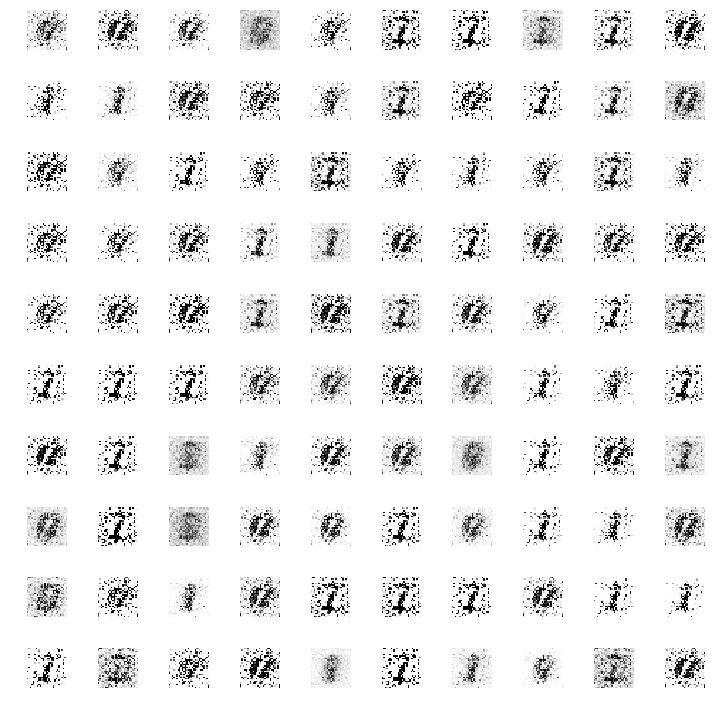

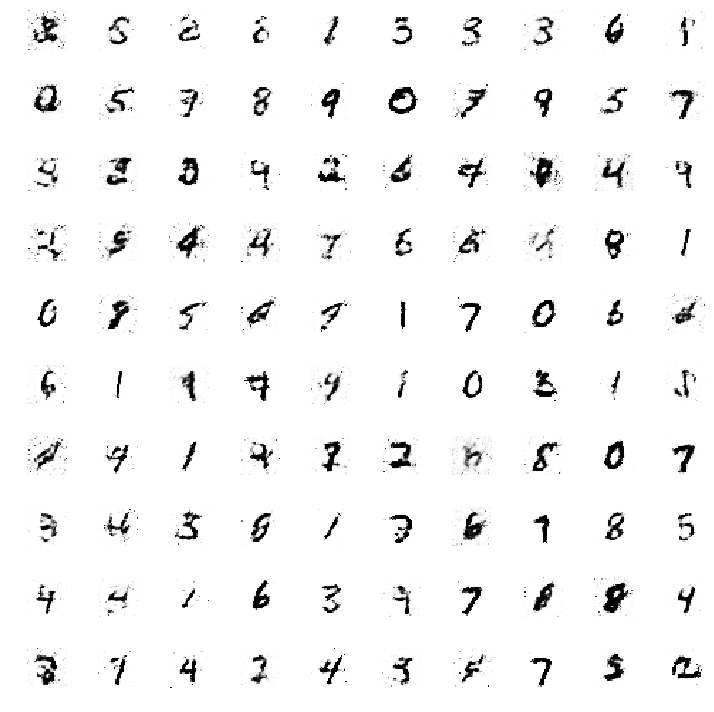

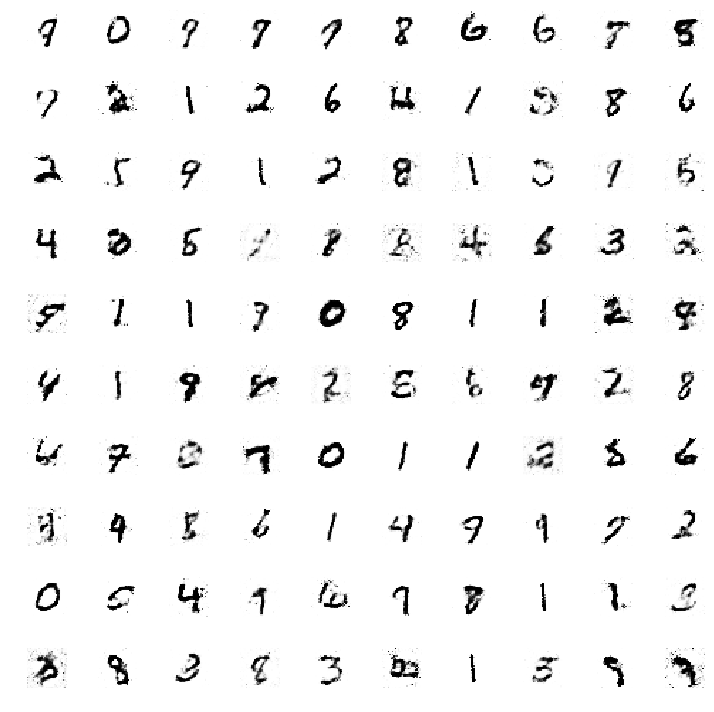

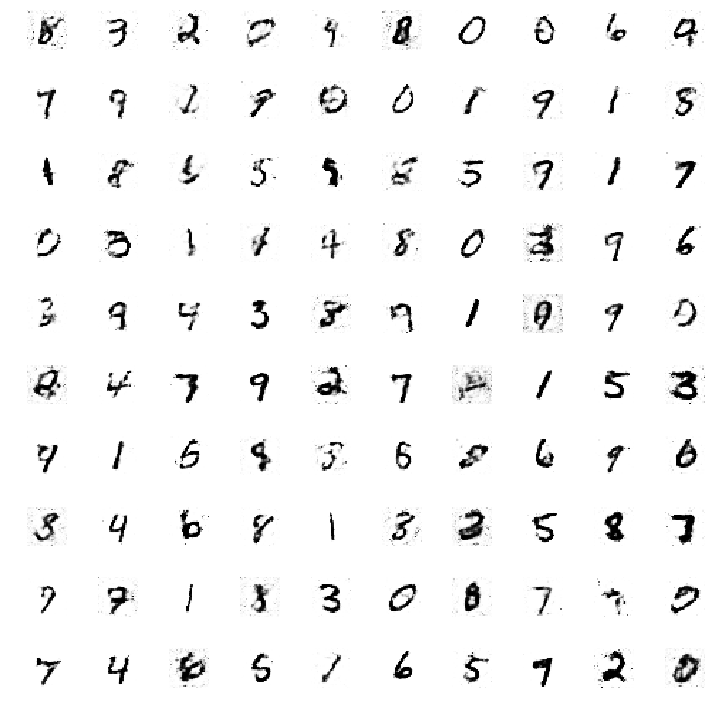

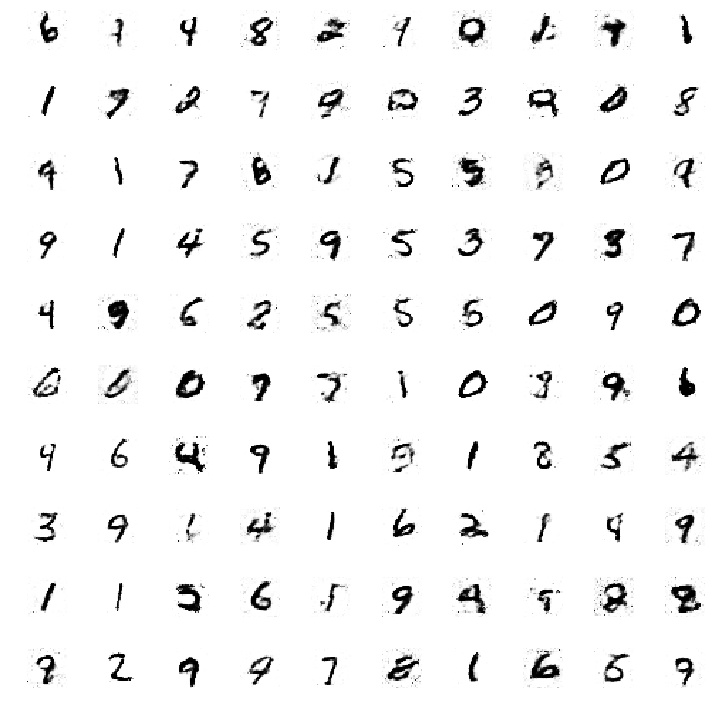

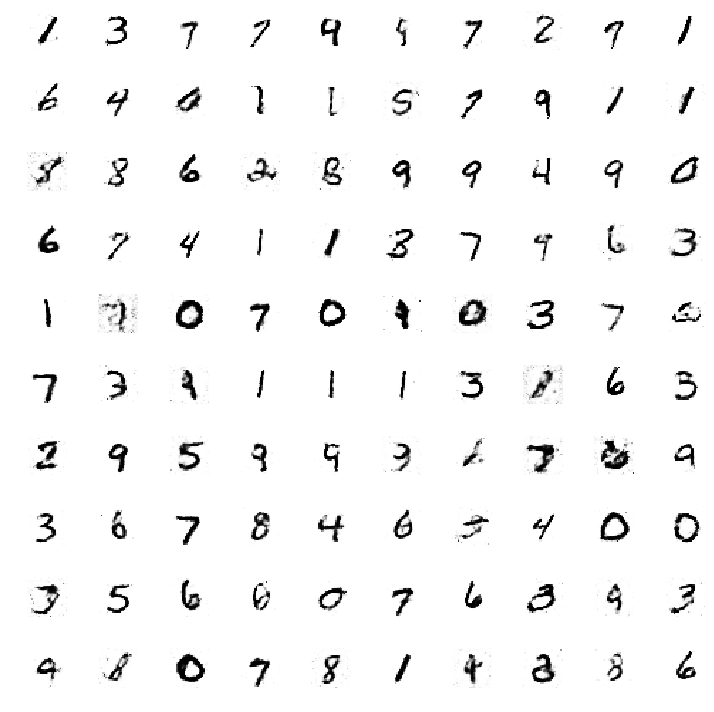

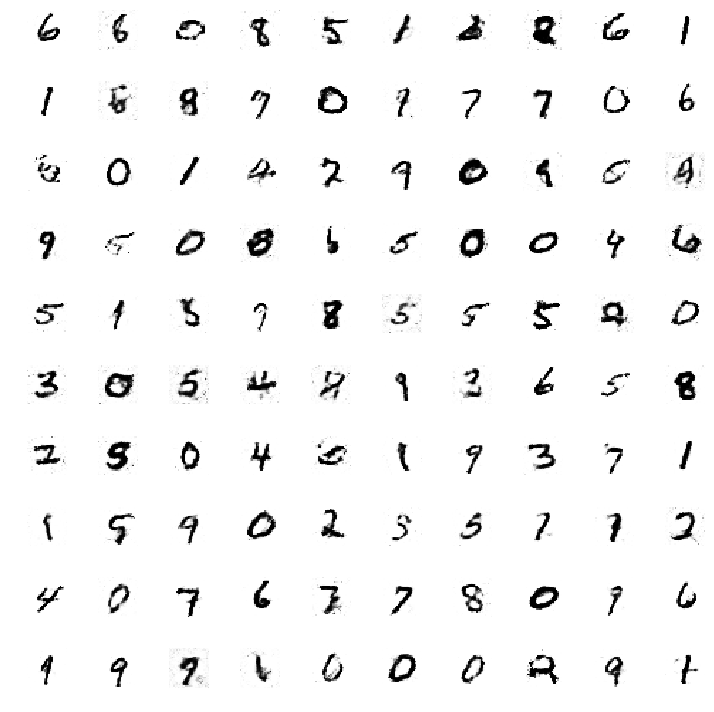

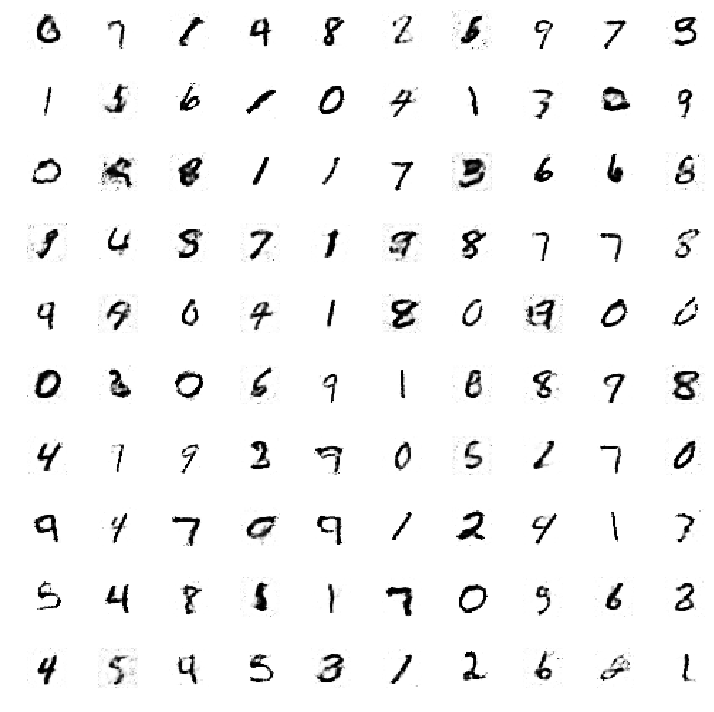

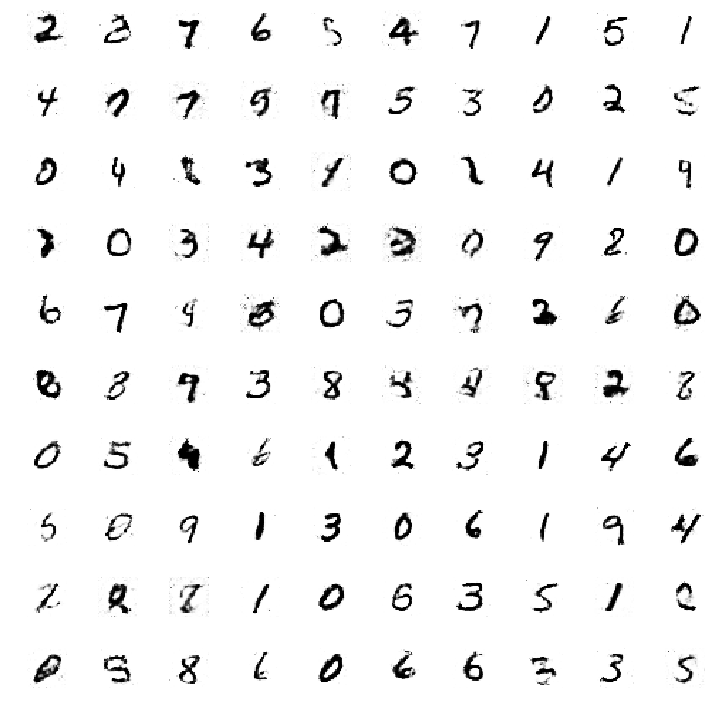

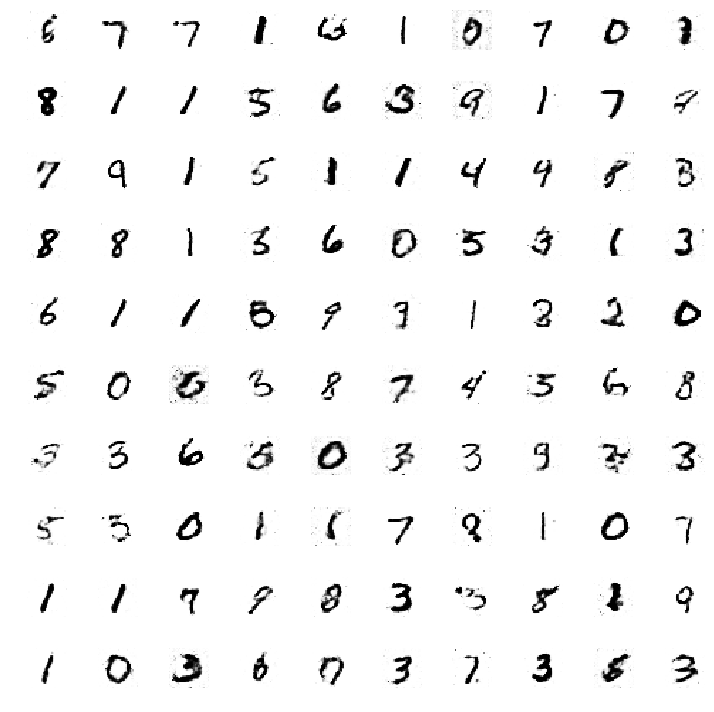

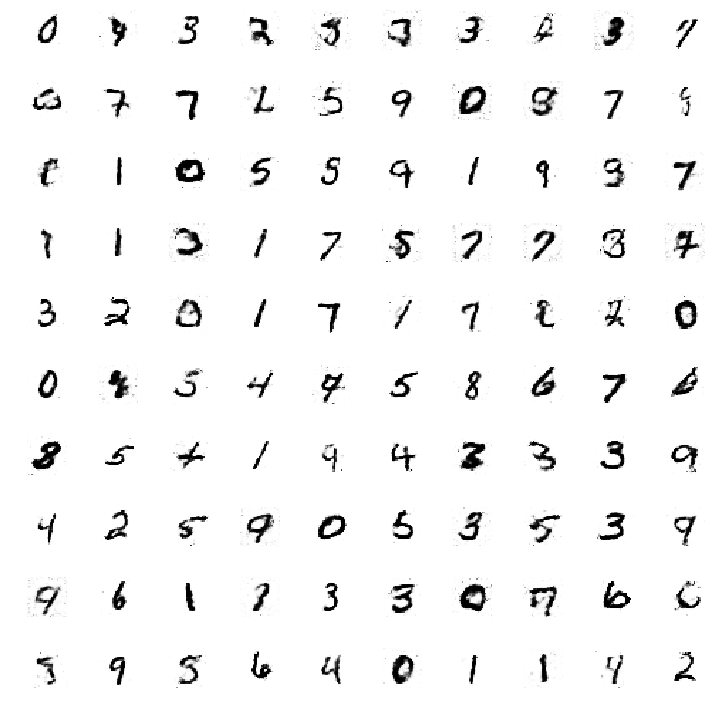

In [0]:
def training(epochs = 1, batch_size = 128):
    
    # Loading data
    (xtrain, ytrain, xtest, ytest) = load_data()
    batch_count = xtrain.shape[0]/batch_size
    
    # Creating Gan
    generator = create_generator()
    discriminator = create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1, epochs+1):
        print("Epoch %d" %e)
        for _ in tqdm(range(int(batch_count))):
            # generate random noise as an input to initialize the generator
            noise = np.random.normal(0,1, [batch_size, 100])
            
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of real images
            image_batch = xtrain[np.random.randint(low = 0, high=xtrain.shape[0], size = batch_size)]
            
            # Construct different batches of real and fake
            x = np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9
            
            # Pre train discriminator on fake and real data before starting gan
            discriminator.trainable = True
            discriminator.train_on_batch(x, y_dis)
            
            # Tricking the nosed input of the Generator as real data
            noise = np.random.normal(0,1,[batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan,
            # the weights of the disriminator should be fixed.
            # We can enforce this by setting the trainable flag
            
            discriminator.trainable= False
            
            # training the GAN by alternating the training of discriminator
            # and training the chained Gan model with discriminator's weights freezed
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e%20 == 0:
            plot_generated_images(e, generator)

training(200, 128)

## here goes DCGAN :=>

In [26]:

def load_data():
    (xtrain, ytrain),(xtest, ytest) = mnist.load_data()
    xtrain = (xtrain.astype(np.float32)-127.5)/127.5
    # 127.5 for centring purposes
    xtrain = xtrain[:,np.newaxis, :, :]
    return (xtrain, ytrain, xtest, ytest)

(xtrain, ytrain, xtest, ytest) = load_data()
print(xtrain.shape)

(60000, 1, 28, 28)


In [0]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1 = 0.5)

In [53]:
def create_generator():
    generator = Sequential()
    generator.add(Dense(units = 128*7*7, input_dim = 100, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))
    generator.add(Reshape((128,7,7)))
    generator.add(UpSampling2D(size=(2,2), data_format = 'channels_first'))

    generator.add(Conv2D(64, kernel_size=(5,5), padding='same', data_format ='channels_first'))
    generator.add(LeakyReLU(0.2))
    generator.add(UpSampling2D(size=(2,2), data_format = 'channels_first'))

    generator.add(Conv2D(1, kernel_size=(5,5), padding='same', activation='tanh', data_format = 'channels_first'))
    generator.compile(loss = 'binary_crossentropy', optimizer = adam_optimizer())

    return generator

generator = create_generator()
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_64 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_19 (Reshape)         (None, 128, 7, 7)         0         
_________________________________________________________________
up_sampling2d_37 (UpSampling (None, 128, 14, 14)       0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 64, 14, 14)        204864    
_________________________________________________________________
leaky_re_lu_65 (LeakyReLU)   (None, 64, 14, 14)        0         
_________________________________________________________________
up_sampling2d_38 (UpSampling (None, 64, 28, 28)        0         
__________

In [55]:

def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Conv2D(64, kernel_size=(5,5), strides = (2,2), padding='same', input_shape=(1,28,28), kernel_initializer= initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Conv2D(128, kernel_size=5, strides = 2, padding='same'))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer = adam_optimizer())
    return discriminator

d  = create_discriminator()
d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 1, 14, 64)         44864     
_________________________________________________________________
leaky_re_lu_68 (LeakyReLU)   (None, 1, 14, 64)         0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 1, 14, 64)         0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 1, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_69 (LeakyReLU)   (None, 1, 7, 128)         0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 1, 7, 128)         0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 896)               0         
__________

In [56]:
def create_dcgan(generator, discriminator):
    discriminator.trainable = False
    dcganInput = Input(shape=(100,))
    x = generator(dcganInput)
    dcganOutput = discriminator(x)
    dcgan = Model(inputs=dcganInput, outputs=dcganOutput)
    dcgan.compile(loss = 'binary_crossentropy', optimizer=adam_optimizer())
    return dcgan

dcgan = create_dcgan(generator, d)
dcgan.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 100)               0         
_________________________________________________________________
sequential_35 (Sequential)   (None, 1, 28, 28)         839937    
_________________________________________________________________
sequential_37 (Sequential)   (None, 1)                 250689    
Total params: 1,090,626
Trainable params: 839,937
Non-trainable params: 250,689
_________________________________________________________________


In [0]:

def plot_generated_images( epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise = np.random.normal(0,1,size = [examples, 100])
    generated_images = generator.predict(noise)


    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i,0], interpolation='nearest', cmap = 'gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('/content/gdrive/My Drive/GAN/dcgan_generated_image %d.png' %epoch)
    return

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 1


  0%|          | 2/468 [00:00<00:34, 13.45it/s]

Epoch 2


  0%|          | 2/468 [00:00<00:26, 17.58it/s]

Epoch 3


  0%|          | 2/468 [00:00<00:27, 16.79it/s]

Epoch 4


  0%|          | 2/468 [00:00<00:27, 16.97it/s]

Epoch 5


  0%|          | 2/468 [00:00<00:35, 13.26it/s]

Epoch 6


  0%|          | 2/468 [00:00<00:26, 17.83it/s]

Epoch 7


  0%|          | 2/468 [00:00<00:26, 17.49it/s]

Epoch 8


  0%|          | 2/468 [00:00<00:26, 17.69it/s]

Epoch 9


  0%|          | 2/468 [00:00<00:26, 17.59it/s]

Epoch 10


  0%|          | 2/468 [00:00<00:36, 12.93it/s]

Epoch 11


  0%|          | 2/468 [00:00<00:26, 17.79it/s]

Epoch 12


  0%|          | 2/468 [00:00<00:25, 18.20it/s]

Epoch 13


  0%|          | 2/468 [00:00<00:26, 17.88it/s]

Epoch 14


  0%|          | 2/468 [00:00<00:25, 17.95it/s]

Epoch 15


  0%|          | 2/468 [00:00<00:28, 16.63it/s]

Epoch 16


  0%|          | 2/468 [00:00<00:26, 17.65it/s]

Epoch 17


  0%|          | 2/468 [00:00<00:25, 18.15it/s]

Epoch 18


  0%|          | 2/468 [00:00<00:28, 16.58it/s]

Epoch 19


  0%|          | 2/468 [00:00<00:27, 16.79it/s]

Epoch 20


  0%|          | 2/468 [00:00<00:35, 13.22it/s]

Epoch 21


  0%|          | 2/468 [00:00<00:28, 16.61it/s]

Epoch 22


  0%|          | 2/468 [00:00<00:27, 17.09it/s]

Epoch 23


  0%|          | 2/468 [00:00<00:27, 16.78it/s]

Epoch 24


  0%|          | 2/468 [00:00<00:28, 16.54it/s]

Epoch 25


  0%|          | 2/468 [00:00<00:31, 14.60it/s]

Epoch 26


  0%|          | 2/468 [00:00<00:26, 17.32it/s]

Epoch 27


  0%|          | 2/468 [00:00<00:26, 17.80it/s]

Epoch 28


  0%|          | 2/468 [00:00<00:25, 18.21it/s]

Epoch 29


  0%|          | 2/468 [00:00<00:26, 17.70it/s]

Epoch 30


  0%|          | 2/468 [00:00<00:35, 13.25it/s]

Epoch 31


  0%|          | 2/468 [00:00<00:26, 17.40it/s]

Epoch 32


  0%|          | 2/468 [00:00<00:26, 17.88it/s]

Epoch 33


  0%|          | 2/468 [00:00<00:26, 17.57it/s]

Epoch 34


  0%|          | 2/468 [00:00<00:26, 17.47it/s]

Epoch 35


  0%|          | 2/468 [00:00<00:35, 13.23it/s]

Epoch 36


  0%|          | 2/468 [00:00<00:26, 17.91it/s]

Epoch 37


  0%|          | 2/468 [00:00<00:26, 17.60it/s]

Epoch 38


  0%|          | 2/468 [00:00<00:26, 17.76it/s]

Epoch 39


  0%|          | 2/468 [00:00<00:26, 17.90it/s]

Epoch 40


  0%|          | 2/468 [00:00<00:30, 15.22it/s]

Epoch 41


  0%|          | 2/468 [00:00<00:26, 17.60it/s]

Epoch 42


  0%|          | 2/468 [00:00<00:26, 17.64it/s]

Epoch 43


  0%|          | 2/468 [00:00<00:26, 17.63it/s]

Epoch 44


  0%|          | 2/468 [00:00<00:26, 17.70it/s]

Epoch 45


  0%|          | 2/468 [00:00<00:30, 15.24it/s]

Epoch 46


  0%|          | 2/468 [00:00<00:26, 17.82it/s]

Epoch 47


  0%|          | 2/468 [00:00<00:26, 17.85it/s]

Epoch 48


  0%|          | 2/468 [00:00<00:26, 17.71it/s]

Epoch 49


  0%|          | 2/468 [00:00<00:26, 17.84it/s]

Epoch 50


100%|██████████| 468/468 [00:27<00:00, 17.46it/s]


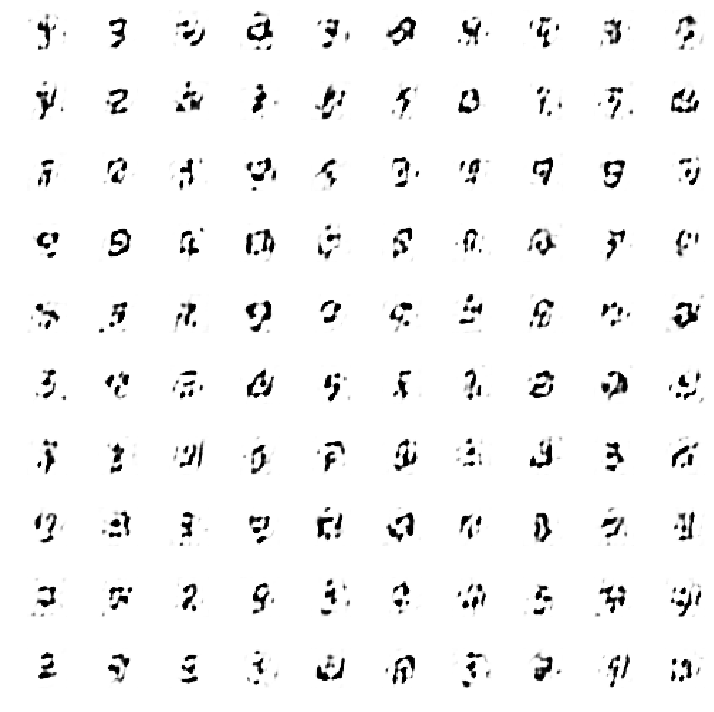

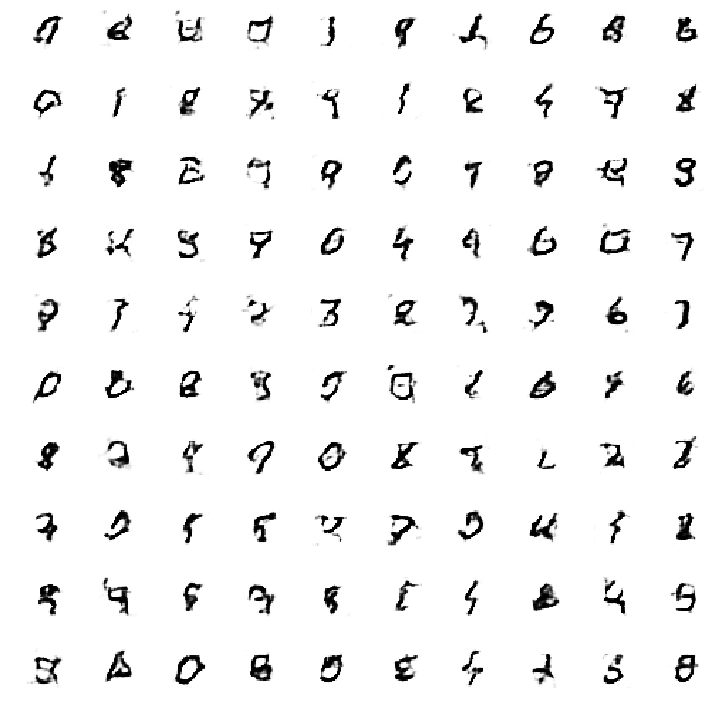

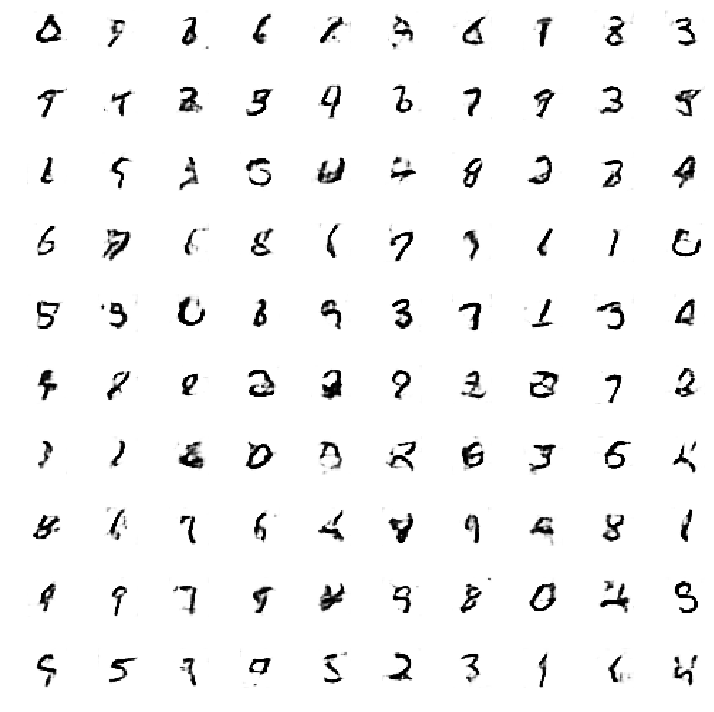

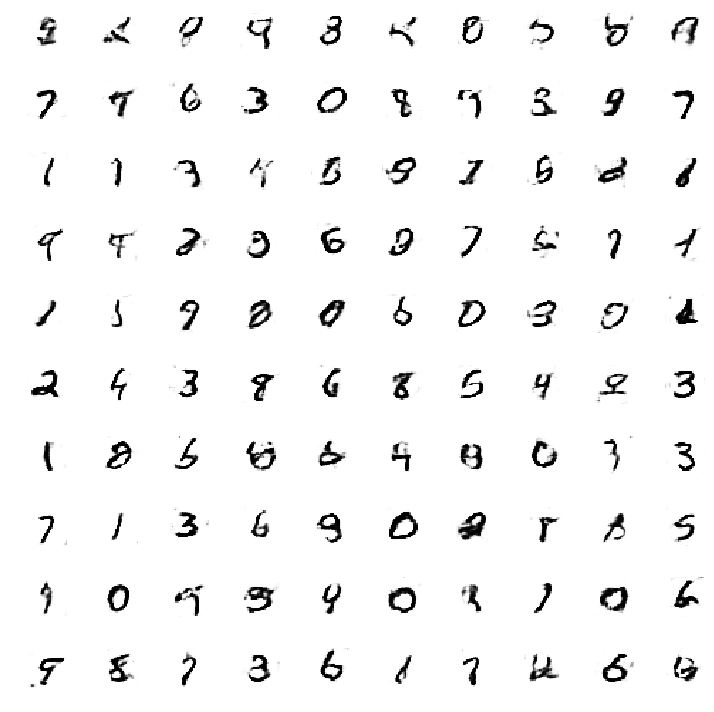

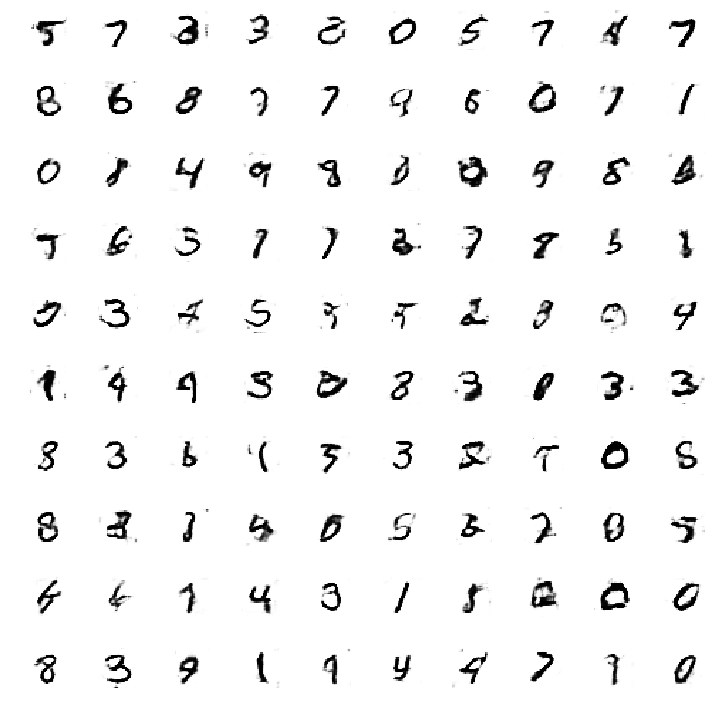

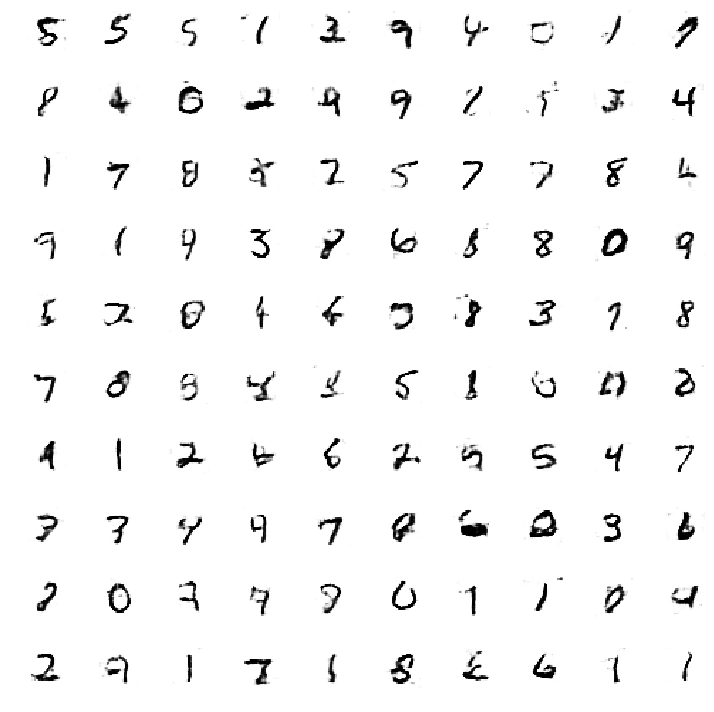

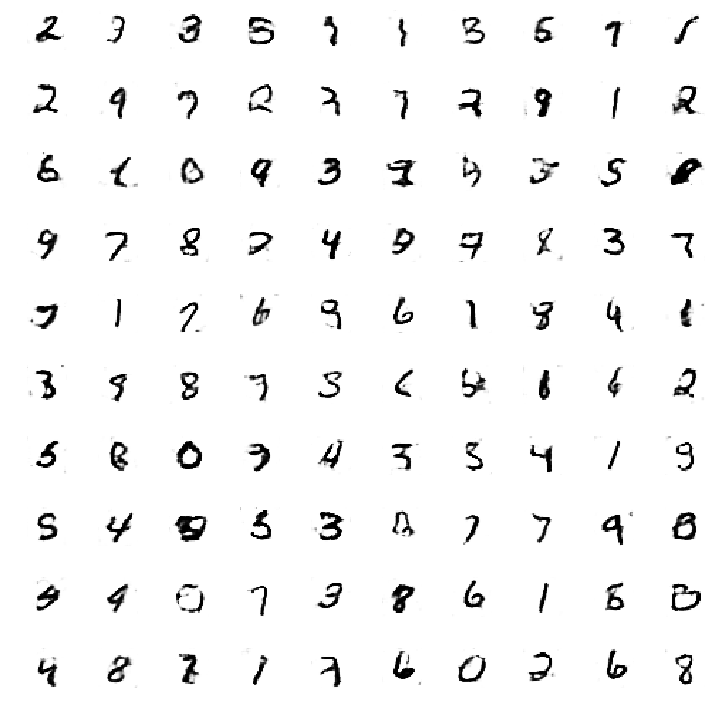

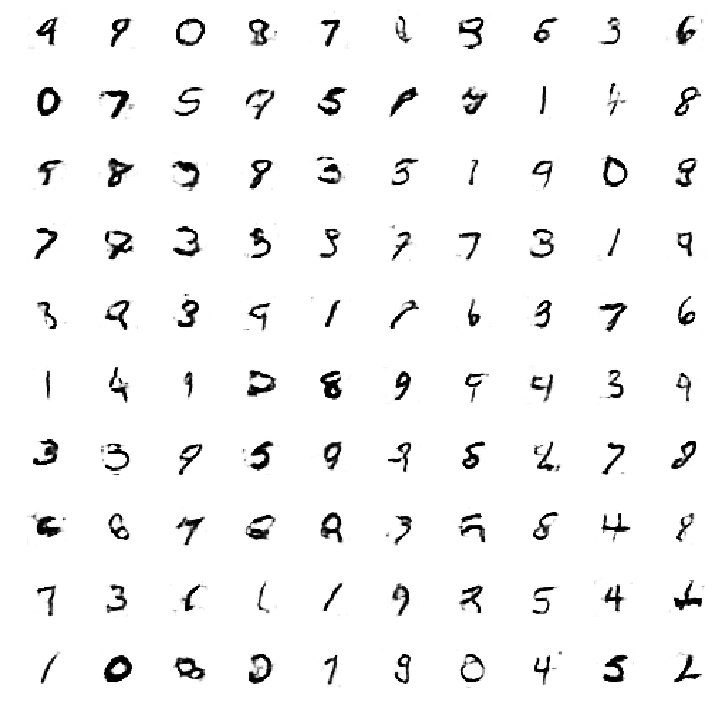

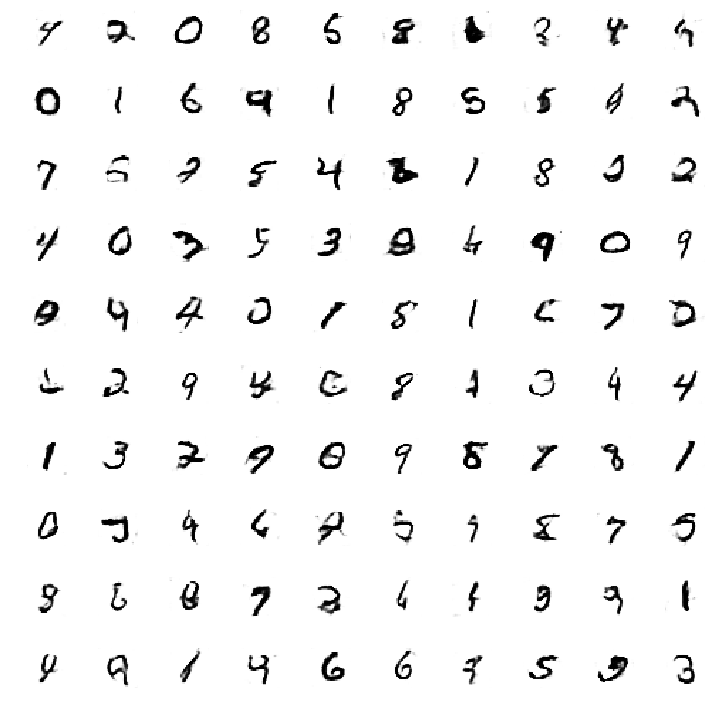

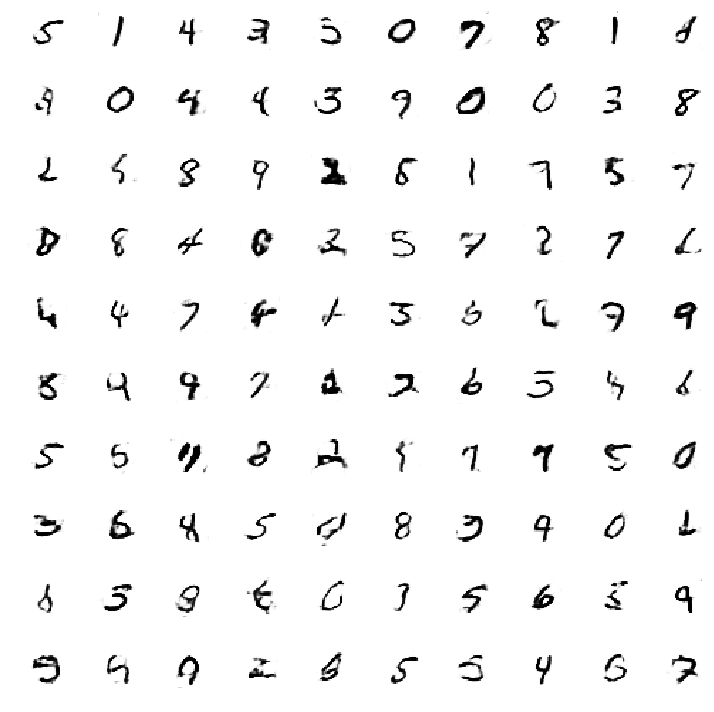

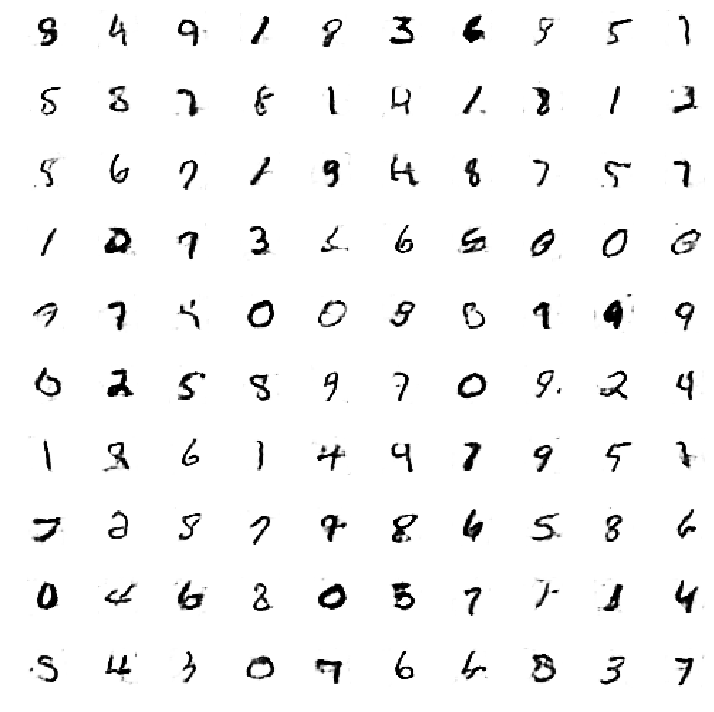

In [58]:

def train(epochs = 1, batch_size = 128):

    ## Loading data 
    (xtrain, ytrain, xtest, ytest) = load_data()
    batch_count = xtrain.shape[0] / batch_size

    # Creating DCGan
    generator = create_generator()
    discriminator = create_discriminator()
    dcgan = create_dcgan(generator, discriminator)

    for e in range(1, epochs+1):
        print("Epoch %d" %e)
        for _ in tqdm(range(int(batch_count))):
            noise = np.random.normal(0,1,size=[batch_size, 100])
            generated_images = generator.predict(noise)
            imageBatch = xtrain[np.random.randint(0, xtrain.shape[0], size= batch_size)]
            X = np.concatenate([imageBatch,generated_images])

            Ydis = np.zeros(2*batch_size)
            Ydis[:batch_size] = 0.9

            discriminator.trainable = True
            discriminator.train_on_batch(X, Ydis)

            noise = np.random.normal(0,1,size=[batch_size, 100])
            Ygen = np.ones(batch_size)
            discriminator.trainable= False
            dcgan.train_on_batch(noise, Ygen)

        if e == 1 or e %5 == 0:
            plot_generated_images(e,generator)

    return

train(50, 128)